In [ ]:
# Importing everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
from tqdm import tqdm
from wordcloud import WordCloud
import os
from dotenv import load_dotenv

nltk.download('punkt')
nltk.download('wordnet')

# Libraries related to ML  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import tensorflow as tf
print(tf.__version__)
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import visualkeras # for visualization of keras models

from openai import OpenAI

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", UserWarning)
# to make tensorflow quiet
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
logging.getLogger('absl').setLevel(logging.ERROR)

load_dotenv()
GROK_API_KEY = os.getenv('GROK_API_KEY')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



2.15.0


# Introduction  

#### Area of interest  
I decided to go for an natrual language processing (NLP) problem, during working on module 4 assignment, I have colncluded that pretrained language models (like BERT) are better then anything simple.  
I would like to dive deepr in this topic, and try to overcome pretrained models performent.  

#### The project & The problem   
As target data I decided to choose Kaggle competition dedicated to NLP.  
The target is to predict marks of essays.
https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview    
It is dedicated to automatic essay scoring - the goal of this competition is to train a model to score student essays.  
This topic is of great interest for me, as I have done a lot of peer review during MSDS studies, and I found them important for myself, as there is always something to learn when you check others' work.  
So, in general, I would go against such an automatic essay checking system, yet it is interesting to implement one.  
The data and project was organizied by Vanderbilt University and the Learning Agency Lab.  

**Files**:  
train.csv - the training set  
test.csv - the test set  
sample_submission.csv - a sample submission file in the correct format   

**GitHub repo**: https://github.com/IMosia/essay_evaluation  

# Exploratory Data Analysis - Meeting the Data  

#### Uploading the data

In [5]:
train_df = pd.read_csv('learning-agency-lab-automated-essay-scoring-2/train.csv')
test_df = pd.read_csv('learning-agency-lab-automated-essay-scoring-2/test.csv')

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Train Data Shape: (17307, 3)
Test Data Shape: (3, 2)


##### Info on train

In [6]:
train_df.info()
train_df.drop(columns=['essay_id'], inplace=True) # there is no need for essay_id in the analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


##### Missing & Duplicates check

In [7]:
print("Missing values in train_df:\n", train_df.isnull().sum())
print("Duplicates in train_df:", train_df.duplicated().sum())

Missing values in train_df:
 full_text    0
score        0
dtype: int64
Duplicates in train_df: 0


#### About the scores column

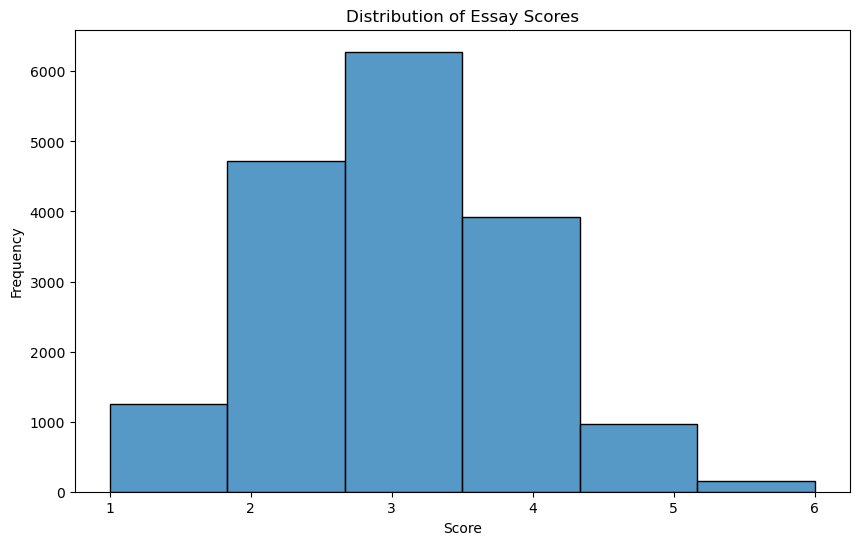

,score,pc of Total
0,3,36.0
1,2,27.0
2,4,23.0
3,1,7.0
4,5,6.0
5,6,1.0


In [48]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['score'], bins=6)
plt.title('Distribution of Essay Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

def count_values_percentage(df, column):
    counts = round(df[column].value_counts(normalize=True), 2) * 100
    return pd.DataFrame(counts).reset_index().rename(columns={'index': column, column: 'pc of Total'})


score_percentage = count_values_percentage(train_df, 'score')
display(score_percentage.sort_values(by='pc of Total', ascending=False, ignore_index=True))


#### The text column

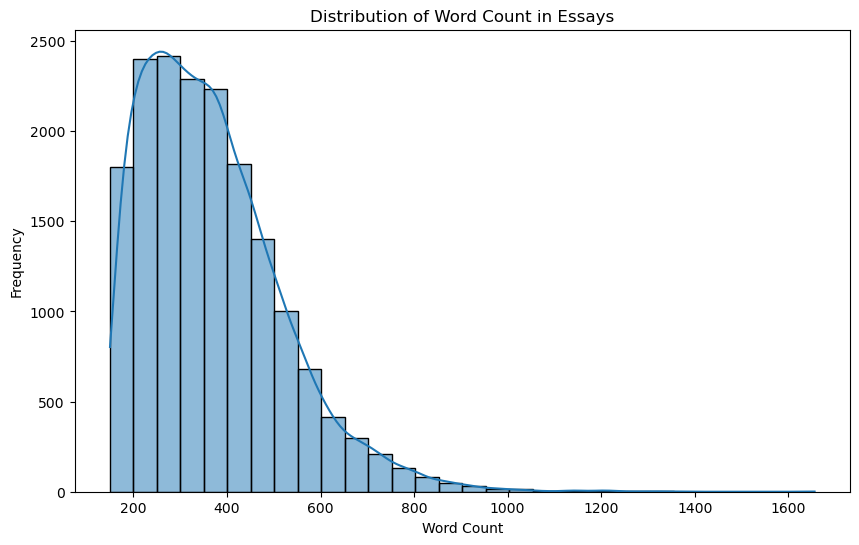

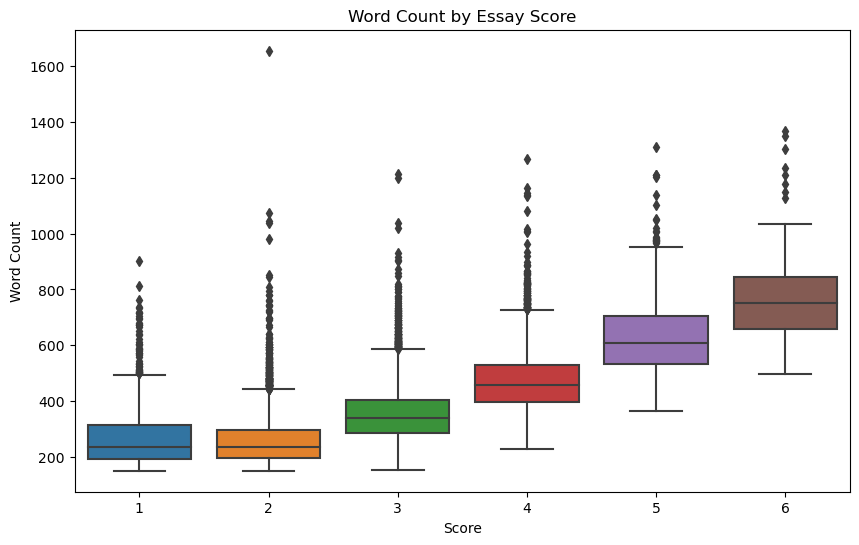

Correlation between word count and score: 0.6900348867544487
Removing # essays 1 with more than 1500 words


In [ ]:
def count_words(text):
    return len(text.split())

train_df['word_count'] = train_df['full_text'].apply(count_words)

# Barplot for word count
plt.figure(figsize=(10, 6))
sns.histplot(train_df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Essays')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['score'], y=train_df['word_count'])
plt.title('Word Count by Essay Score')
plt.xlabel('Score')
plt.ylabel('Word Count')
plt.show()

# Correlation with target variable
print("Correlation between word count and score:", train_df['word_count'].corr(train_df['score']))

print(f"Removing # essays {len(train_df[train_df['word_count'] > 1500])} with more than 1500 words")
train_df = train_df[train_df['word_count'] <= 1500]


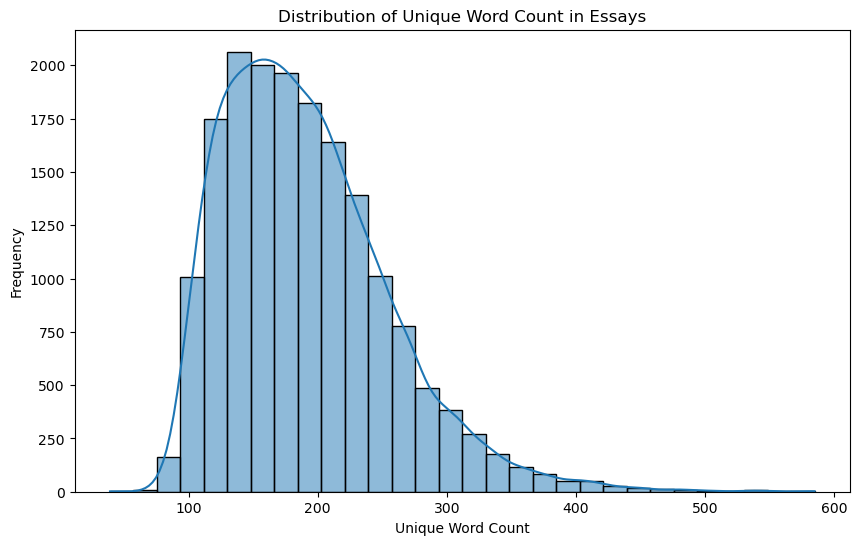

Correlation between unique word count and score: 0.6459692847559573
Correlation between word count and unique word count: 0.93747902977549


In [10]:
# number of unique words
def count_unique_words(text):
    return len(set(text.split()))

train_df['unique_word_count'] = train_df['full_text'].apply(count_unique_words)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['unique_word_count'], bins=30, kde=True)
plt.title('Distribution of Unique Word Count in Essays')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()

print("Correlation between unique word count and score:", train_df['unique_word_count'].corr(train_df['score']))
print("Correlation between word count and unique word count:", train_df['word_count'].corr(train_df['unique_word_count']))

train_df.drop(columns=['unique_word_count'], inplace=True)

Total unique words in the corpus: 129564
Most frequent words in the corpus (without stopwowrds):
 would         43621
people        32362
cars          32012
car           30530
could         29338
like          22452
Venus         21637
get           17266
also          16948
think         15582
many          15503
driverless    15211
help          15084
even          14129
one           13191
technology    13070
make          12954
vote          11612
know          11528
author        11125
dtype: int64


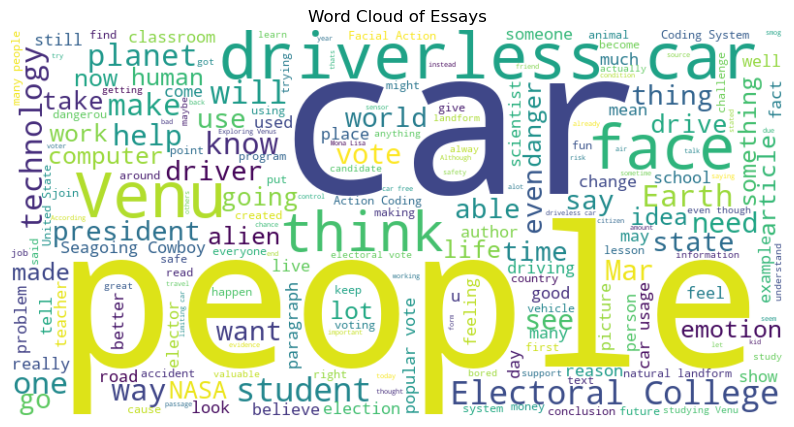

In [11]:
def count_total_unique_words(df):
    """All the words count"""
    all_words = ' '.join(df['full_text']).split()
    return len(set(all_words))
print("Total unique words in the corpus:", count_total_unique_words(train_df))

def most_frequent_words(df, top_n=20):
    """Function to claculate the most frequent words without the stopwords"""
    all_words = ' '.join(df['full_text']).split()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    all_words = [word for word in all_words if word.lower() not in stopwords]
    word_freq = pd.Series(all_words).value_counts().head(top_n)
    return word_freq
print("Most frequent words in the corpus (without stopwowrds):\n", most_frequent_words(train_df))

def plot_wordcloud(df):
    all_text = ' '.join(df['full_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Essays')
    plt.show()
plot_wordcloud(train_df)

In [12]:
def display_random_essays(df, n=3):
    random_essays = df.sample(n=n, random_state=42)
    for index, row in random_essays.iterrows():
        print(f"Essay ID: {index}\nScore: {row['score']}\nFull Text:\n{row['full_text']}\n{'-'*80}")
display_random_essays(train_df, n=3)

Essay ID: 8014
Score: 4
Full Text:
You should join the Seagoing Cowboys program because you would be helping animals get to other countries, you would be able to visit exciting places and countries and you woudn't have to be bored on the ship because you can do fun activities. I have to arn you, you might face dangerous situations.

If you join the Seagoing Cowboys program you would be helping animals that weres shipped overseas. You would be helping animals such as horses, young cows and mules. You would be feeding the animals, giving them water clean their stalls and you would have to pull bales of hay and bags of oats to the lower holds of the ship. If you join the program you would also be able to visit exciting places and countries, I got to visit the Acropolis in Greece, an excavated castle in Crete and I marveled at the Panama Canal on my way to China. Some places I visited were Europe, China, Greece, Italy and Crete. One of the most exciting things I have ever done was when I t

#### EDA conclusion  
The training dataset contains **17307** samples. While the test dataset contains only 3 example, which is unexpectedly low number.  
There are no missing or duplicated samples in the training dataset.  
In the training data there are only 3 columns - id (ommited), the text itself and score (target).  
The score column is unbalanced, with most of the grades being between 2 and 4, and small number of values of 1, 5, and especially 6.  
Lenght of essay has a strong correlation with the grade (something which may be used later for ML), there are many outliers in terms of 1.5IQR, however, they are all nicely group, with the only exeption of one of essays with score 2 and 1700 words - this example was removed.  
Number of unique words has also a strong correlation with target score, however, it is extremely correlated with length of essay.  
There is total number of 129564 unique words in the training dataset.  
The text of essay preesents relatively clean English text.  

# Preprocessing  
#### Plan  
There are several steps.  
- Take 20% as validation dataset    
- Prepare version of text with cleaning and lemmatization  
- Make a set of TF-IDF embedings with different number of features to test how this will influence models performance  

#### Splitting

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=['score'])
    , train_df['score']
    , test_size=0.2
    , random_state=42
)

#### Cleaned version

In [ ]:
%%time

def clean_text(text):
    """
    Function to clean the text data by:
        - Lowercasing the text
        - Expanding contractions
        - Removing URLs (if there are any)
        - Removing special characters and punctuation
        - Tokenizing the text
        - Removing stopwords
        - Lemmatizing the tokens
    """
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

tqdm.pandas(desc="Cleaning Text Data")
X_train['cleaned_text'] = X_train['full_text'].progress_apply(clean_text)
X_val['cleaned_text'] = X_val['full_text'].progress_apply(clean_text)

Cleaning Text Data: 100%|██████████| 3462/3462 [00:12<00:00, 278.07it/s]

CPU times: total: 59.2 s
Wall time: 59.2 s


#### TF-IDF  
Several feature set sizes to test

In [12]:
def vectorize_text(train, val, column='cleaned_text', num_features=1000):
    """
    To apply TF-IDF vectorization to the text data.
    """
    vectorizer = TfidfVectorizer(max_features=num_features)
    X_train_vec = vectorizer.fit_transform(train[column])
    X_val_vec = vectorizer.transform(val[column])
    return X_train_vec, X_val_vec, vectorizer

set_of_tf_idf_features = {}
options_for_tf_idf = [100, 500, 1000, 3000, 10000]

for num_features in tqdm(options_for_tf_idf, desc="Vectorizing Text Data"):
    X_train_vec, X_val_vec, vectorizer = vectorize_text(X_train, X_val, num_features=num_features)
    set_of_tf_idf_features[num_features] = {
        'X_train': X_train_vec,
        'X_val': X_val_vec,
        'vectorizer': vectorizer
    }


Vectorizing Text Data: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]


# Modeling & Analysis  
There are several types of models which I am interested in to compare.  
The aim is to compare various deep learnign approach (custom nn, small size LLM, big moder LLM) to each other and to classical ML approaches.  

#### Dummy, Linear Regression & Boosting  
Use classical ML algorythms for the NLP problem.  

#### A Designed Neural Net  
Create a small neural net to do the predictions.  

#### BERT  
User BERT pretrained model.  

#### Modern LLM  
Try zero-shot LLM analysis on small subset of data to see if it can outperform everything else.   

#### Issues  
- custom metric has to be implemented  
- class disbalance has to be adressed  
- type of problem  

#### Which ML problem is it?  
This is surprisingly not a straitforward question.  
The target has 6 possible states: 1, 2, 3, 4, 5, 6  
It may be considered as ordinal variables and a classification problem, or as regression on finite set of outcomes.  
I will try both approaches, but main focus will be on the regression problem with small subset of possible values.  

#### The metric  
Descrbtion taken from the Kaggle competition    

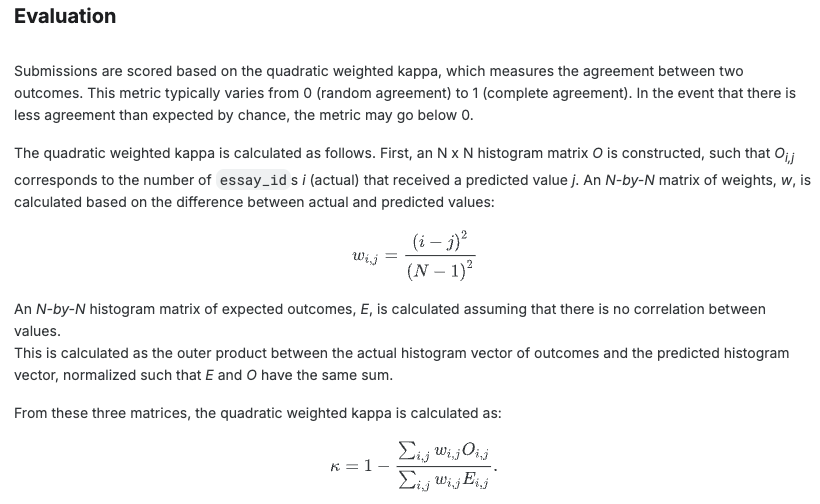

#### Preparations  

In [13]:
results_df = pd.DataFrame(columns=['model'
                                   , 'features_set'
                                   , 'train_score'
                                   , 'val_score'
                                   , 'best_hyperparameters'])


def add_results(model_name, features_set, train_score, val_score, best_hyperparameters=None):
    """
    Results df is where all the information will be storred
    """
    global results_df
    temp_df = pd.DataFrame({
        'model': [model_name],
        'features_set': [features_set],
        'train_score': [train_score],
        'val_score': [val_score],
        'best_hyperparameters': [best_hyperparameters]
    })
    if results_df.empty:
        results_df = temp_df
    else:
        results_df = pd.concat([results_df, temp_df], ignore_index=True)


def quadratic_weighted_kappa(actual, predicted, N=6):
    """
    Calculate the quadratic weighted kappa as it is the main metric
    N - number of possible ratings
    """
    actual = np.array(actual)
    predicted = np.array(predicted)

    # not all models will predict the exact value, so we need to round
    predicted = np.round(predicted).astype(int)

    # if any predicted value > 6 or < 1, we need to clip it
    if np.any(predicted < 1) or np.any(predicted >= N):
        np.clip(predicted, 1, N, out=predicted)

    # convert to 0-based indexing if ratings are 1-based
    # this is needed for correct indexing in the confusion matrix
    actual_idx = actual - 1 
    predicted_idx = predicted - 1

    # histogram matrix O 
    O = np.zeros((N, N))

    for i, j in zip(actual_idx, predicted_idx):
        O[i, j] += 1

    # weight matrix w
    w = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            w[i, j] = ((i - j) ** 2) / ((N - 1) ** 2)

    # matrix of expected outcomes E
    actual_hist = np.sum(O, axis=1)
    predicted_hist = np.sum(O, axis=0)
    E = np.outer(actual_hist, predicted_hist) / np.sum(O)

    # quadratic weighted kappa
    numerator = np.sum(w * O)
    denominator = np.sum(w * E)

    if denominator == 0:
        raise ValueError("Denominator is zero, cannot compute kappa.")

    kappa = 1 - (numerator / denominator)
    return kappa


#### Dummy, Linear Regression & Boosting  
For dummy I choose 2 options - prediction with mean as classical dummy for regression.  
The second dummy is prediction based on single feature - length of the essay.  

Linear regression and boosting will be both traind on TF-IDF.  

For boosting a small hyperparameter optimization will be performed.

In [14]:
def dummy_predictor_mean(X_train, X_val, y_train):
    """
    Dummy predictor that predicts the mean of the training set
    """
    mean_score = y_train.mean()
    y_pred_train = np.full_like(y_train, mean_score)
    y_pred_val = np.full_like(y_val, mean_score)

    train_score = quadratic_weighted_kappa(y_train, y_pred_train)
    val_score = quadratic_weighted_kappa(y_val, y_pred_val)
    add_results('Dummy Predictor', 'Mean Score', train_score, val_score)

dummy_predictor_mean(X_train, X_val, y_train)


def linear_regression_with_word_count(X_train, X_val, y_train):
    """
    Linear Regression model with word count as a feature
    """
    X_train_lr = X_train[['word_count']]
    X_val_lr = X_val[['word_count']]

    model = LinearRegression()
    model.fit(X_train_lr, y_train)

    y_pred_train = model.predict(X_train_lr)
    y_pred_val = model.predict(X_val_lr)

    train_score = quadratic_weighted_kappa(y_train, y_pred_train)
    val_score = quadratic_weighted_kappa(y_val, y_pred_val)

    add_results('Linear Regression', 'Word Count', train_score, val_score)
    return y_pred_val

linear_regression_with_word_count(X_train, X_val, y_train)


array([2.96025596, 3.66208626, 2.85930776, ..., 2.14305629, 3.18138057,
       2.03730104])

In [15]:
def train_linear_regression(X_train, y_train, X_val, y_val):
    """
    Train a linear regression model and evaluate it using quadratic weighted kappa.
    """
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    
    train_score = quadratic_weighted_kappa(y_train, train_predictions)
    val_score = quadratic_weighted_kappa(y_val, val_predictions)
    
    return model, train_score, val_score

# training and evaliation linear regression
for num_features, data in tqdm(set_of_tf_idf_features.items(), desc="Training Linear Regressor"):
    X_train_vec = data['X_train']
    X_val_vec = data['X_val']
    
    model, train_score, val_score = train_linear_regression(X_train_vec, y_train, X_val_vec, y_val)
    
    add_results(
        model_name='Linear Regression',
        features_set=f'TF-IDF {num_features} features',
        train_score=train_score,
        val_score=val_score
    )

Training Linear Regressor: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


In [16]:
%%time
hyperparameters = {
    'num_leaves': [6, 12, 24], # 6 or variations as we have 6 possible scores
    'max_depth': [-1, 1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

def train_lgbm_regressor(X_train, y_train, X_val, y_val, params):
    """
    Train a LightGBM regressor and evaluate it using quadratic weighted kappa.
    """
    model = LGBMRegressor(**params
                          , class_weight='balanced' # we add balanced as there is an imbalance in the dataset
                          , objective='regression'
                          , random_state=42
                          , verbose=-1) 
    model.fit(X_train
              , y_train)

    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    train_score = quadratic_weighted_kappa(y_train, train_predictions)
    val_score = quadratic_weighted_kappa(y_val, val_predictions)

    return model, train_score, val_score

def grid_search_lgbm(X_train, y_train, X_val, y_val, hyperparameters):
    """
    Perform grid search for hyperparameters of LightGBM regressor.
    """
    best_score = -np.inf
    best_train_score = -np.inf
    best_params = None
    best_model = None

    for num_leaves in hyperparameters['num_leaves']:
        for max_depth in hyperparameters['max_depth']:
            for learning_rate in hyperparameters['learning_rate']:
                for n_estimators in hyperparameters['n_estimators']:
                    params = {
                        'num_leaves': num_leaves,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'n_estimators': n_estimators
                    }
                    model, train_score, val_score = train_lgbm_regressor(
                        X_train, y_train, X_val, y_val, params
                    )

                    if val_score > best_score:
                        best_score = val_score
                        best_params = params
                        best_model = model
                        best_train_score = train_score

    return best_model, best_params, best_score, best_train_score

for num_features, data in tqdm(set_of_tf_idf_features.items(), desc="Training LightGBM Regressor"):
    X_train_vec = data['X_train']
    X_val_vec = data['X_val']

    best_model, best_params, best_score, best_train_score = grid_search_lgbm(
        X_train_vec, y_train, X_val_vec, y_val, hyperparameters
    )

    add_results(
        model_name='LightGBM Regressor',
        features_set=f'TF-IDF {num_features} features',
        train_score=best_train_score, # it is best for the best val score, not the best in general
        val_score=best_score,
        best_hyperparameters=best_params
    )

Training LightGBM Regressor: 100%|██████████| 5/5 [1:07:31<00:00, 810.26s/it] 

CPU times: total: 8h 43min 6s
Wall time: 1h 7min 31s


In [17]:
display(results_df.sort_values(by='val_score'
                               , ascending=False
                               , ignore_index=True))

# as everything works slow I decided to make backups for the results
results_df.to_csv('classical_ml_results.csv', index=False)

,model,features_set,train_score,val_score,best_hyperparameters
0,LightGBM Regressor,TF-IDF 3000 features,0.872285,0.753500,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
1,LightGBM Regressor,TF-IDF 10000 features,0.886765,0.751608,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
2,LightGBM Regressor,TF-IDF 1000 features,0.884821,0.750737,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
3,LightGBM Regressor,TF-IDF 500 features,0.862831,0.746538,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
4,LightGBM Regressor,TF-IDF 100 features,0.811196,0.688554,"{'num_leaves': 24, 'max_depth': 5, 'learning_r..."
5,Linear Regression,TF-IDF 3000 features,0.776585,0.673828,None
6,Linear Regression,TF-IDF 1000 features,0.687931,0.649993,None
7,Linear Regression,Word Count,0.629186,0.640083,None
8,Linear Regression,TF-IDF 500 features,0.625226,0.611847,None
9,Linear Regression,TF-IDF 10000 features,0.936382,0.446135,None


#### Results for classical ML  
Classical models already provided reasonable results, even world-count dummy model has score of 0.64.  
Interesting observation is how 10000 features dataset leads to overfittings, as both LGBM and Linear Regression have higher train score with this dataset, and lower validation score.

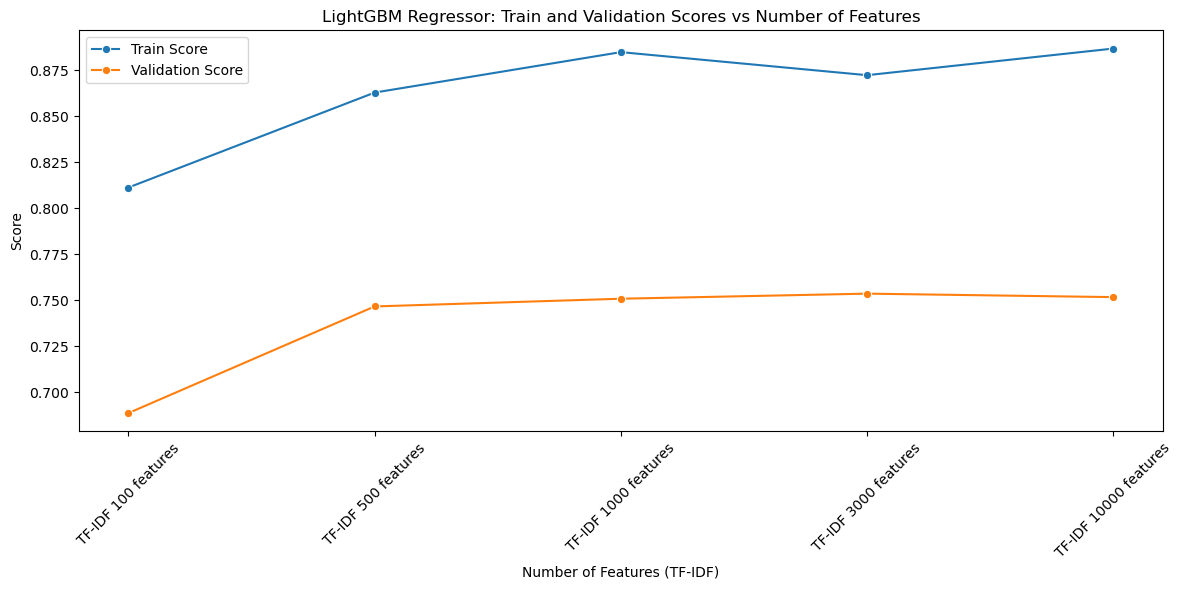

In [ ]:
# a graph to demonstrate how increased number of features affects the model performance
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df[results_df['model'] == 'LightGBM Regressor']
             , x='features_set'
             , y='train_score'
             , label='Train Score'
             , marker='o')
sns.lineplot(data=results_df[results_df['model'] == 'LightGBM Regressor']
             , x='features_set'
             , y='val_score'
             , label='Validation Score'
             , marker='o')
plt.title('LightGBM Regressor: Train and Validation Scores vs Number of Features')
plt.xlabel('Number of Features (TF-IDF)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# be adviced - the x scale is categorical - not numerical !!! 

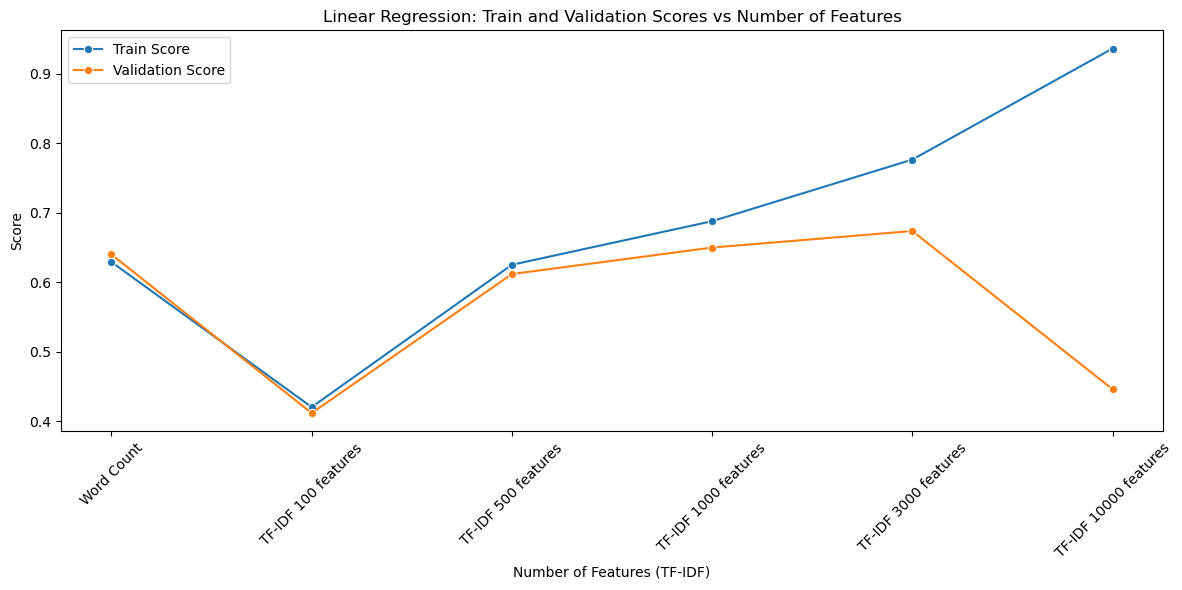

In [ ]:
# a graph to demonstrate how increased number of features affects the model performance #2
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df[results_df['model'] == 'Linear Regression']
             , x='features_set'
             , y='train_score'
             , label='Train Score'
             , marker='o')
sns.lineplot(data=results_df[results_df['model'] == 'Linear Regression']
             , x='features_set'
             , y='val_score'
             , label='Validation Score'
             , marker='o')
plt.title('Linear Regression: Train and Validation Scores vs Number of Features')
plt.xlabel('Number of Features (TF-IDF)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# be adviced - the x scale is categorical - not numerical !!!

#### A Designed Neural Net  

Similary I would like to make several models and compare their performance on all the TF-IDF feature sets.  

There are 5 architectures to test:  
1 - simple model with 1 dense layer and 6 output neurons with linear activation  
2 - similar model with dropout added  
3 - similar as 1 but with additional deeper layer  
4 - similar as 1 but with softmax activation for the last layer and classification-like optiomization  
5 - similar to 1 but with 1 output neuron

In [43]:
def build_model(input_dim, version=1, only_model_structure=False):
    """
    A function to build neural net from several architectures for regression with 6 outputs
    """
    model = Sequential()

    if version == 1:
        # Simple model with 1 inner layer
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dense(6, activation='linear'))

    elif version == 2:
        # Simple model with dropout
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.5))
        model.add(Dense(6, activation='linear'))

    elif version == 3:
        # Model with 2 layers deep
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(6, activation='linear'))

    elif version == 4:
        # Classification-like approach with 6 output neurons
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dense(6, activation='softmax'))  # softmax for classification-like output

    elif version == 5:
        # Simple model like 1 but with only 1 output neuron
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dense(1, activation='linear'))
    else:
        raise ValueError(f"Unsupported model version: {version}")

    if only_model_structure:
        return model

    if version == 4:
        # classification-like compilation
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    else:
        # regression compilation
        model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mae', 'mse']
        )

    return model


def train_neural_network(X_train, y_train, X_val, y_val, input_dim, version=1, balance_classes=False):
    """
    Train a neural network model and evaluate it using quadratic weighted kappa.
    """
    # correct format to have dense input
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
    if hasattr(X_val, 'toarray'):
        X_val = X_val.toarray()


    model = build_model(input_dim, version)

    if balance_classes:
        # Icalculate class balance from training
        class_counts = np.bincount(y_train - 1)
        total_count = len(y_train)
        class_weights = {i - 1: total_count / (len(class_counts) * count) for i, count in enumerate(class_counts, start=1) if count > 0}
        
        # train with class weights
        # the models works more stable when classes starts from 0
        # for both training and validation
        y_train = y_train - 1

        history = model.fit(X_train, y_train, epochs=12, batch_size=32, verbose=0, class_weight=class_weights)
    else:
        # no balancing
        y_train = y_train - 1
        history = model.fit(X_train, y_train, epochs=12, batch_size=32, verbose=0)

    # Predict
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    # correction for +1 back to the original scale
    train_predictions = np.argmax(train_predictions, axis=1) + 1
    y_train = y_train + 1  # revert back to original scale
    val_predictions = np.argmax(val_predictions, axis=1) + 1

    # Calculate scores
    train_score = quadratic_weighted_kappa(y_train, train_predictions)
    val_score = quadratic_weighted_kappa(y_val, val_predictions)

    return history, model, train_score, val_score


version_short_descriptions = {
    1: "Base",
    2: "+ Dropout",
    3: "+ 1 hidden layer",
    4: "Classification-like",
    5: "1 output neuron"
}


In [20]:
%%time
for num_features, data in tqdm(set_of_tf_idf_features.items(), desc="Training Neural Networks"):
    X_train_vec = data['X_train']
    X_val_vec = data['X_val']

    input_dim = X_train_vec.shape[1]

    for balance_classes in [True, False]:  # with and without balancing
        for version in range(1, 6):  # Training models with different architectures
            history, model, train_score, val_score = train_neural_network(
                X_train_vec, y_train, X_val_vec, y_val, input_dim, version, balance_classes
            )

            add_results(
                model_name=f'Neural Network {version_short_descriptions[version]}' + (' (Balanced)' if balance_classes else ''),
                features_set=f'TF-IDF {num_features} features',
                train_score=train_score,
                val_score=val_score
            )


Training Neural Networks:   0%|          | 0/5 [00:00<?, ?it/s]





109/109 [==============================] - 0s 2ms/step


Training Neural Networks:  20%|██        | 1/5 [02:35<10:22, 155.60s/it]

109/109 [==============================] - 0s 2ms/step


Training Neural Networks:  40%|████      | 2/5 [05:21<08:05, 161.89s/it]

109/109 [==============================] - 0s 2ms/step


Training Neural Networks:  60%|██████    | 3/5 [08:39<05:56, 178.13s/it]

109/109 [==============================] - 0s 2ms/step


Training Neural Networks:  80%|████████  | 4/5 [13:33<03:44, 224.01s/it]

109/109 [==============================] - 0s 3ms/step


Training Neural Networks: 100%|██████████| 5/5 [26:55<00:00, 323.19s/it]

CPU times: total: 2h 29min 31s
Wall time: 26min 55s


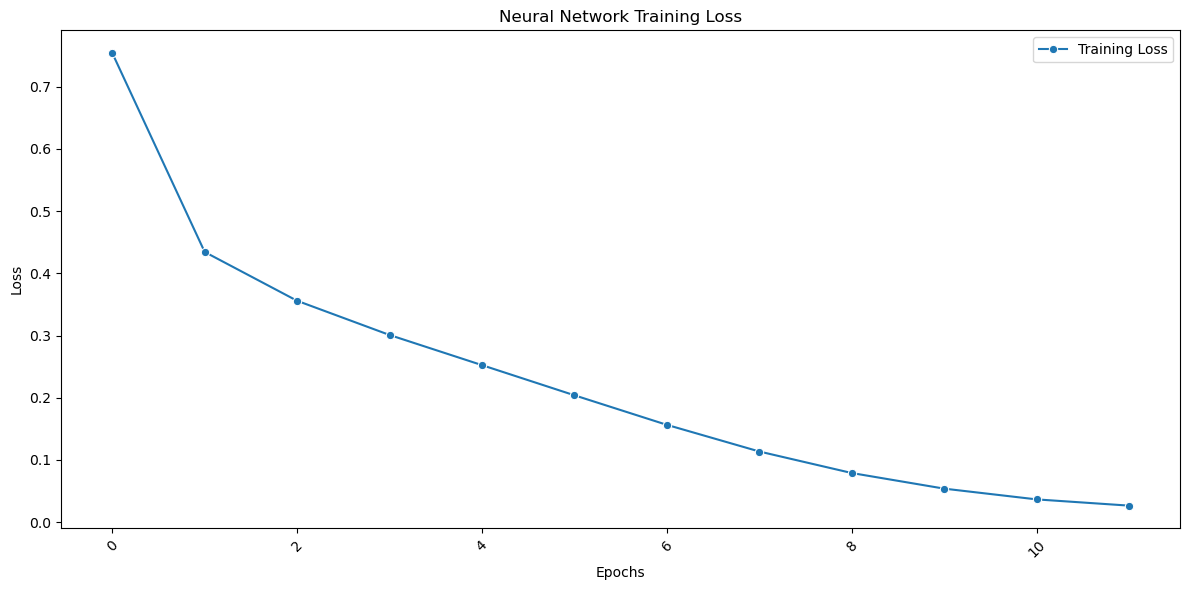

In [21]:
# History for the last model only as illustration
plt.figure(figsize=(12, 6))
sns.lineplot(data=history.history['loss'], label='Training Loss', marker='o')
plt.title('Neural Network Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for version in range(1, 6):
    print(f"Visualizing Neural Network Version {version} | {version_short_descriptions[version]}") # jsut to have this text for md
    model = build_model(input_dim=X_train.shape[1], version=version, only_model_structure=True)
    visualkeras.layered_view(model, to_file=f'neural_network_version_{version}.png', legend=True)

Visualizing Neural Network Version 1 | Base
Visualizing Neural Network Version 2 | + Dropout
Visualizing Neural Network Version 3 | + 1 hidden layer
Visualizing Neural Network Version 4 | Classification-like
Visualizing Neural Network Version 5 | 1 output neuron


Visualizing Neural Network Version 1 | Base  
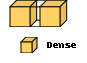  

Visualizing Neural Network Version 2 | + Dropout  
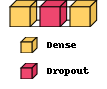  

Visualizing Neural Network Version 3 | + 1 hidden layer  
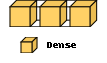  

Visualizing Neural Network Version 4 | Classification-like  
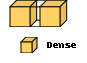  


Visualizing Neural Network Version 5 | 1 output neuron  
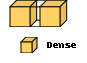

In [22]:
display(results_df[results_df['model'].str.contains('Neural Network')
                   ].sort_values(by='val_score', ascending=False, ignore_index=True)
                   )

results_df.to_csv('neural_network_results.csv', index=False)

,model,features_set,train_score,val_score,best_hyperparameters
0,Neural Network Classification-like,TF-IDF 1000 features,0.827746,0.633849,None
1,Neural Network Classification-like (Balanced),TF-IDF 3000 features,0.913821,0.632902,None
2,Neural Network Classification-like,TF-IDF 3000 features,0.974187,0.606110,None
3,Neural Network Classification-like (Balanced),TF-IDF 1000 features,0.758506,0.603550,None
4,Neural Network Classification-like,TF-IDF 500 features,0.745611,0.600361,None
5,Neural Network Classification-like (Balanced),TF-IDF 10000 features,0.997933,0.578824,None
6,Neural Network Classification-like (Balanced),TF-IDF 500 features,0.657817,0.567565,None
7,Neural Network Classification-like,TF-IDF 10000 features,0.999967,0.558312,None
8,Neural Network Classification-like,TF-IDF 100 features,0.595140,0.528549,None
9,Neural Network Classification-like (Balanced),TF-IDF 100 features,0.465404,0.436789,None


##### Neural Nets Results  
With the clasiffication apprach results were much better then in any other case.  
Suprisingly, balancing classes did not improve the results.  
To many features let to overfitting similary to classical models.  
Regression did not perform well for this problem nor with 6, nor with 1 output neuron.

#### BERT  
BERT (Bidirectional Encoder Representations from Transformers) is one of the first modern LLM introduced by Google in 2018. It is based on transformers atchitecture and is capable to understand meaning of text.  
Before the end of 2023 and start of GPT era, it was industrial standard for workind with text.  

I will use distilled version, it is almost as good, but much faster (https://huggingface.co/distilbert/distilbert-base-uncased).  

In [ ]:
def build_bert_model(model_name = 'distilbert-base-uncased'):
    """
    Build a BERT model for regression.
    """
    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

    bert_model = TFAutoModel.from_pretrained(model_name)
    bert_output = bert_model(input_ids, attention_mask=attention_mask)

    x = bert_output.last_hidden_state[:, 0, :] 
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1)(x) # output layer for regression

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)
    model.compile(optimizer=Adam(learning_rate=2e-5)
                  , loss='mean_squared_error'
                  , metrics=['mean_squared_error'])
    
    return model

def train_bert_model(X_train, y_train, X_val, y_val, test=False, model_name = 'distilbert-base-uncased'):
    """
    Train a BERT model for regression.
    """
    if test: # for quick experimentation
        X_train = X_train.sample(n=32, random_state=42)
        y_train = y_train[X_train.index]
    else:
        # BERT is very memory intensive, so we limit the number of samples
        # but it also performs good on smaller datasets
        X_train = X_train.sample(n=2048, random_state=42)  
        y_train = y_train[X_train.index]

    # predictions are also very demanding
    X_val = X_val.sample(n=256, random_state=42)
    y_val = y_val[X_val.index]

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # tokenization
    train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='tf')
    val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, return_tensors='tf')

    model = build_bert_model(model_name)

    # training
    history = model.fit(
        x={'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
        y=y_train,
        validation_data=(
            {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
            y_val
        ),
        epochs=1, # BERT as efficient but the process is extremely long
        batch_size=8,
        verbose=1
    )

    # evaluation
    train_predictions = model.predict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']})
    val_predictions = model.predict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']})

    train_score = quadratic_weighted_kappa(y_train, train_predictions)
    val_score = quadratic_weighted_kappa(y_val, val_predictions)

    return history, model, train_score, val_score

In [34]:
%%time
possible_features = ['full_text', 'cleaned_text']
for feature in possible_features:
    X_train_bert = X_train[feature]
    X_val_bert = X_val[feature]

    history, model, train_score, val_score = train_bert_model(
        X_train_bert, y_train, X_val_bert, y_val, test=False
    )

    add_results(
        model_name='distilled BERT Model',
        features_set=f'{feature} (2048 samples)',
        train_score=train_score,
        val_score=val_score
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


8/8 [==============================] - 94s 12s/step


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


8/8 [==============================] - 96s 12s/step
CPU times: total: 22h 46min 35s
Wall time: 1h 58min 29s


In [35]:
display(results_df[results_df['model'].str.contains('BERT')].sort_values(by='val_score'
                                                                    , ascending=False
                                                                    , ignore_index=True))

results_df.to_csv('bert_results.csv', index=False)
# first was with 512 training examples

,model,features_set,train_score,val_score,best_hyperparameters
0,distilled BERT Model,full_text (2048 samples),0.682985,0.717434,None
1,distilled BERT Model,cleaned_text (2048 samples),0.698395,0.704248,None
2,distilled BERT Model,cleaned_text,0.573260,0.592602,None
3,distilled BERT Model,full_text,0.372549,0.338288,None


##### BERT results  
Unfortunately, BERT is extremely resource demanding and it was not possible to run it on full training dataset on my local PC.  
However, even with very small subset (2048 examples) it performed greatly, almost similar for cleaned and usual text.  
Rows 2 and 3 in the table correspond to the first trial with 512 training examples - remarkable improve for the increase in the training set allows to assume that with full training set, the results would be outstanding, however even on 2048 samples I had to wait for 2 hours.

#### Modern LLM  
Modern approach contains with jsut using a provided LLM.  
There are many different prompting options, I will try several:  
- zero shot, only model instruction  
- zero shot with instructions  
- with several examples  
Due to the economic resons, I will not make full validation, only 30 examples for each case.  

In [26]:
prompts_dictionary = {
    # only the model instruction is provided
    "vague": "", 
    # classical life-threatening prompt
    "instruction": "6 is outstanding, 5 is excellent, 4 is good, 3 is fair, 2 is poor, and 1 is very poor. \n\n YOU MUST BE VERY PRECISE AS MY LIFE AND LIFE OF A THOUSAND STUDENTS DEPENDS ON YOUR ANSWER. \n\n",
    
    # few-shot prompt with examples
    "few_shot": """Here are some examples of essays and their scores:\n\n
Score: 4
Full Text:
You should join the Seagoing Cowboys program because you would be helping animals get to other countries, you would be able to visit exciting places and countries and you woudn't have to be bored on the ship because you can do fun activities. I have to arn you, you might face dangerous situations.

If you join the Seagoing Cowboys program you would be helping animals that weres shipped overseas. You would be helping animals such as horses, young cows and mules. You would be feeding the animals, giving them water clean their stalls and you would have to pull bales of hay and bags of oats to the lower holds of the ship. If you join the program you would also be able to visit exciting places and countries, I got to visit the Acropolis in Greece, an excavated castle in Crete and I marveled at the Panama Canal on my way to China. Some places I visited were Europe, China, Greece, Italy and Crete. One of the most exciting things I have ever done was when I took a gondola ride in Venice, Itlay. Another reason why you should join is because, when you're on the ship you get to do activities such as playing baseball, volleyball, Table-tennis, fencing, boxing, and if you want you can read.

I have to warn you, you could get hurt because when I was aboard on the ship one day, I slid down a slippery laddery on my backside, my heart raced as I shot feet towards an openingon the side of the ship. Luckilly a small strip of metal along the edge of the ship stopped me from sliding and keept me from flying aboard into the Atlantic Ocean. I was happy to be alive, but I couldn't work for a couple of days because I had cracked ribs. Even though you might face some dangerous situations when you join this program you still get to, help animals, visit exciting places and countries and do fun activities while you are on the ship. Please join the Seagoing Cowboys program, you would be doing a good thing and your family and friends would be proud that you are helping animals and the community.
--------------------------------------------------------------------------------

Score: 3
Full Text:
My position on driverless cars is i personally believe the idea is crazy! I say this because you never what could be the outcome of of this car. Another reason i say this is because these cars still have a driver. There is alot of what if's with this idea. I personally would not a take a chance, and put my life in a cars hands, and i dont believe others should either.

The articles gives give reaonsing to have these cars, and bad reasoning to have these cars. I agree with thwe article on some the good reasonings such as fuel. Sergey says the car he forsees would use half of the fuel of today's taxis, and offer far more flexiability than a bus. This is just a car he forsees, this does not make this a fact about a driverless car. Sergey believes these cars would fundamentally change the world. In my opinon these cars could harm the world.

Google has cars that has driven more than half a million miles without a crash. These cars are the cars that are not completly driverless. The google cars have alert the driver. I personally think this still does not mean anything. I say this because a person may lose their life in a split second, with this being said this car could be a few seconds late to alert the drive and the driver was not paying attention then BOOM! Theses cars have alot of what if's, and i definitely will not be looking forward to find out one.

Inconclusion these are my reasons i believe this idea is. This is my opinon and you never maybe these cars will revelousionize the world, but theres always a chance that these cars may cause damage to the world as well. As you can see i dont believe these cars will be very useful. I also dont believe these cars will as Sergey saod fundamentally change the world. I could not put my life on technology. If i dont ride roller coasters why should i ride in a driverless car?                     

######
Evaluate this  essay on a scale from 1 to 6, where 1 is very poor and 6 is outstanding!
"""

}

def build_prompt(essay, mode='vague'):
    """
    Combined predifined prompt and the essay
    """
    base_prompt = prompts_dictionary.get(mode, None)
    if base_prompt is None:
        raise ValueError(f"Unknown mode: {mode}")
    return base_prompt + f"\n\nEssay:\n{essay}"


client_grok = OpenAI(
    api_key=GROK_API_KEY,
    base_url="https://api.x.ai/v1",
)

model_constant = """
You are an expert essay evaluator.  
Your task is to evaluate the quality of essays based on their content, structure, and clarity.  
Provide a score from 1 to 6, where 1 is the lowest quality and 6 is the highest quality.  
You MUST PROVIDE ONLY the score as an integer, without any additional text or explanation.
"""

def query_llm(prompt, test=False):
    """
    Function to query the LLM (Grok) with the given prompt
    """

    try:
        completion = client_grok.chat.completions.create(
                    model='grok-3',
                    messages=[
                        {"role": "system"
                                , "content": model_constant},
                        {"role": "user"
                                , "content": prompt},
                    ],
                )
         
        ai_response = completion.choices[0].message.content

        if test:
            print(f"LLM response: {ai_response}")

        try:
            score = int(re.search(r'\b(\d+)\b', ai_response).group(1))
            if score < 1 or score > 6:
                print(f"Invalid score {score} from LLM, defaulting to 1")
                return 1 # Default to 1 if parsing fails
            return score

        except:
            print(f"Invalid response from LLM: {ai_response}")
            return 1  

    except Exception as e:
        print(f"Error querying LLM: {e}")
        return 1


def process_essas_with_llm(test=True):
    """
    Orchestrating function to process essays with LLM
    """
    # taking subsample
    llm_eval_df = X_val.copy()
    llm_eval_df['score'] = y_val
    llm_eval_df = llm_eval_df.sample(n=30, random_state=42)

    if test:
        llm_eval_df = llm_eval_df.sample(n=1, random_state=42) # for test only 1 essay is enough

    for mode in ['vague', 'instruction', 'few_shot']: # iterate over different modes of prompts
        predictions = []
        for essay in tqdm(llm_eval_df['full_text'], desc=f"LLM {mode}"):
            prompt = build_prompt(essay, mode=mode)
            score = query_llm(prompt, test=test)
            predictions.append(score)

        kappa = quadratic_weighted_kappa(llm_eval_df['score'], predictions)
        print(f"LLM ({mode}) QWK score on 30 samples: {kappa:.3f}")
        add_results(
            model_name=f'LLM ({mode})',
            features_set='Full text',
            train_score=kappa,
            val_score=kappa
        )


In [27]:
process_essas_with_llm(test=False)

LLM vague: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


LLM (vague) QWK score on 30 samples: 0.442


LLM instruction: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


LLM (instruction) QWK score on 30 samples: 0.386


LLM few_shot: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

LLM (few_shot) QWK score on 30 samples: 0.489


In [28]:
display(results_df[results_df['model'].str.contains('LLM')]
       .sort_values(by='val_score', ascending=False, ignore_index=True))

results_df.to_csv('llm_results.csv', index=False)

,model,features_set,train_score,val_score,best_hyperparameters
0,LLM (few_shot),Full text,0.489362,0.489362,None
1,LLM (vague),Full text,0.441860,0.441860,None
2,LLM (instruction),Full text,0.385965,0.385965,None


##### Results for Modern LLM  
I choose Grok as it provides 250$ for free for API usage upon registration, if one agrees to share data, this data I do not mind to share. Still, I used only subset of data, as I was woried about the price.  
Results are moderate, suprisingly low with examples given. Simpel detailed instruction is the best, yet still underperform to all other tested approaches.  

### Results comparison

In [ ]:
display(results_df.sort_values(by='val_score'
                               , ascending=False
                               , ignore_index=True).head(20))

,model,features_set,train_score,val_score,best_hyperparameters
0,LightGBM Regressor,TF-IDF 3000 features,0.872285,0.753500,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
1,LightGBM Regressor,TF-IDF 10000 features,0.886765,0.751608,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
2,LightGBM Regressor,TF-IDF 1000 features,0.884821,0.750737,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
3,LightGBM Regressor,TF-IDF 500 features,0.862831,0.746538,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
4,distilled BERT Model,full_text (2048 samples),0.682985,0.717434,NaN
5,distilled BERT Model,cleaned_text (2048 samples),0.698395,0.704248,NaN
6,LightGBM Regressor,TF-IDF 100 features,0.811196,0.688554,"{'num_leaves': 24, 'max_depth': 5, 'learning_r..."
7,Linear Regression,TF-IDF 3000 features,0.776585,0.673828,NaN
8,Linear Regression,TF-IDF 1000 features,0.687931,0.649993,NaN
9,Linear Regression,Word Count,0.629186,0.640083,NaN


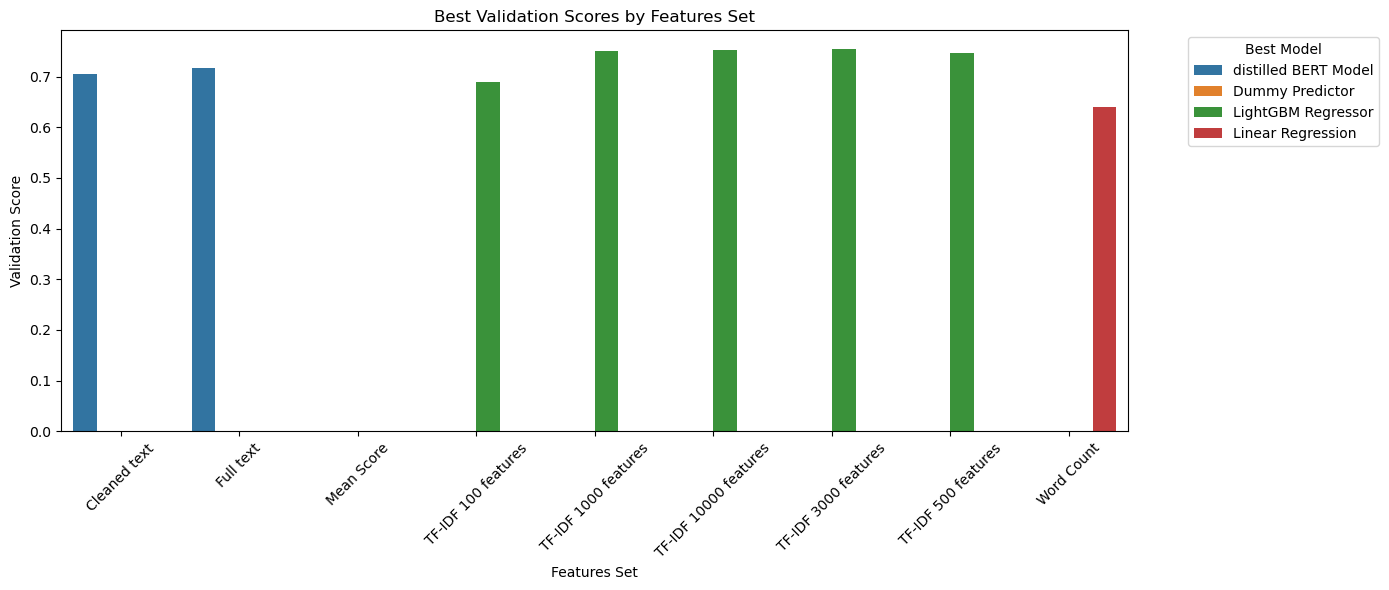

,model,features_set,train_score,val_score,best_hyperparameters
0,LightGBM Regressor,TF-IDF 3000 features,0.872285,0.753500,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
1,LightGBM Regressor,TF-IDF 10000 features,0.886765,0.751608,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
2,LightGBM Regressor,TF-IDF 1000 features,0.884821,0.750737,"{'num_leaves': 24, 'max_depth': -1, 'learning_..."
3,LightGBM Regressor,TF-IDF 500 features,0.862831,0.746538,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
4,distilled BERT Model,Full text,0.682985,0.717434,NaN
5,distilled BERT Model,Cleaned text,0.698395,0.704248,NaN
6,LightGBM Regressor,TF-IDF 100 features,0.811196,0.688554,"{'num_leaves': 24, 'max_depth': 5, 'learning_r..."
7,Linear Regression,Word Count,0.629186,0.640083,NaN
8,Dummy Predictor,Mean Score,0.000000,0.000000,NaN


In [46]:
results_df['features_set'] = results_df['features_set'].replace({
    'full_text': 'Full text',
    'full_text (2048 samples)': 'Full text',
    'Full text (2048 samples)': 'Full text',
    'cleaned_text': 'Cleaned text',
    'cleaned_text (2048 samples)': 'Cleaned text',
})
grouped_df_by_features = results_df.loc[results_df.groupby('features_set')['val_score'].idxmax()]

plt.figure(figsize=(14, 6))
bars = sns.barplot(data=grouped_df_by_features, x='features_set', y='val_score', hue='model')
plt.title('Best Validation Scores by Features Set')
plt.xlabel('Features Set')
plt.ylabel('Validation Score')
plt.xticks(rotation=45)
plt.legend(title='Best Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

display(grouped_df_by_features.sort_values(by='val_score', ascending=False, ignore_index=True))


TF-IDF with 3000 features was generally better then with 10k on all models, later set caused overfitting of models.  
Full text without any preprocessing was consumed well both by BERT and LLM.

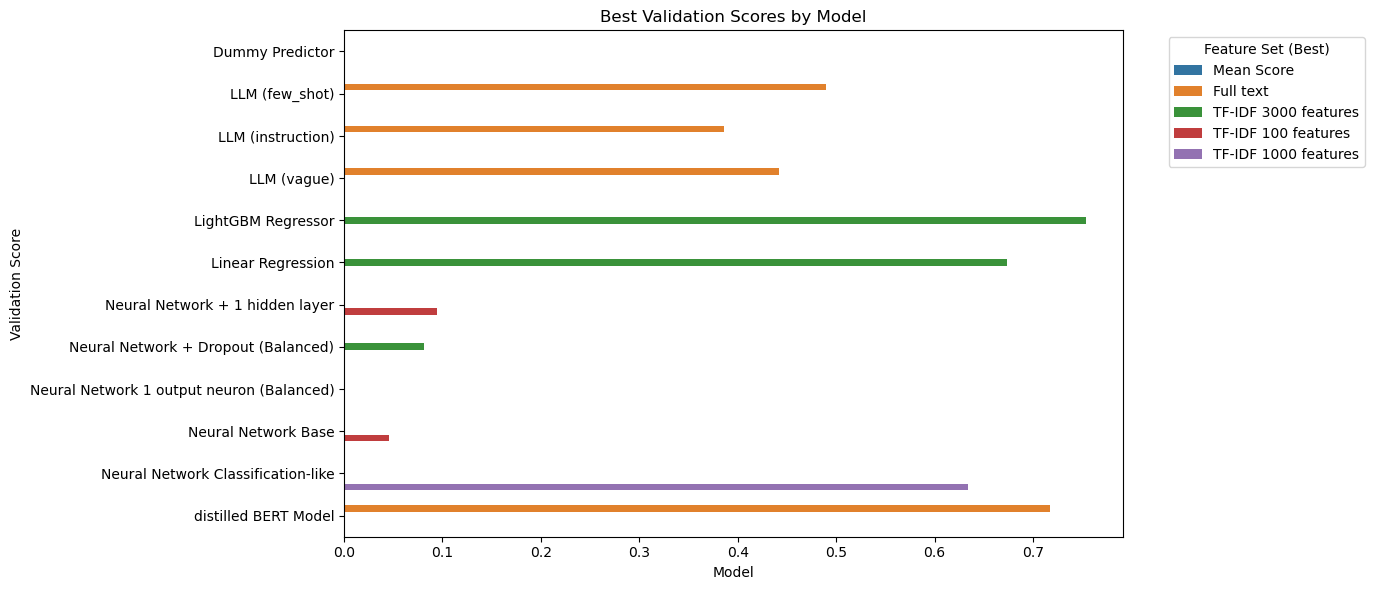

,model,features_set,train_score,val_score,best_hyperparameters
0,LightGBM Regressor,TF-IDF 3000 features,0.872285,0.753500,"{'num_leaves': 12, 'max_depth': -1, 'learning_..."
1,distilled BERT Model,Full text,0.682985,0.717434,NaN
2,Linear Regression,TF-IDF 3000 features,0.776585,0.673828,NaN
3,Neural Network Classification-like,TF-IDF 1000 features,0.827746,0.633849,NaN
4,LLM (few_shot),Full text,0.489362,0.489362,NaN
5,LLM (vague),Full text,0.441860,0.441860,NaN
6,LLM (instruction),Full text,0.385965,0.385965,NaN
7,Neural Network + 1 hidden layer,TF-IDF 100 features,0.047446,0.094505,NaN
8,Neural Network + Dropout (Balanced),TF-IDF 3000 features,0.098885,0.081513,NaN
9,Neural Network Base,TF-IDF 100 features,0.028854,0.045470,NaN


In [47]:
# Balanced from neural nets
# this is needed to group the NN models without separation if the target was balanced or not
results_df_cleaned = results_df.copy()
results_df_cleaned['model'] = results_df_cleaned['model'].str.replace(r' \(Balanced\)\s*', '', regex=True).str.strip()
grouped_df_by_features = results_df.loc[results_df_cleaned.groupby('model')['val_score'].idxmax()]

plt.figure(figsize=(14, 6))
bars = sns.barplot(data=grouped_df_by_features, y='model', x='val_score', hue='features_set', orient='h')
plt.title('Best Validation Scores by Model')
plt.xlabel('Model')
plt.ylabel('Validation Score')
plt.legend(title='Feature Set (Best)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

display(grouped_df_by_features.sort_values(by='val_score', ascending=False, ignore_index=True))

Boosting model on TF-IDf performed the best, even though I assume that BERT would outperform it with more compute power.  
Surprisingly, Liner regression was better then Grok 3 for this task.  
Custom neural net demonstrate performance comparable with linear regresion, however, they are hard to tune for each task, while LR works out of box.

#### Submission  
This competition is code-based, so this operation was done on the Kaggle platform.  
Submission notebook which was used for the Kaggle submission can be found on GitHub.  

In [36]:
best_model = results_df.loc[results_df['model'] == 'LightGBM Regressor'].sort_values(by='val_score', ascending=False).iloc[0]

print('Hyperparameters of the best model:', best_model['best_hyperparameters'])

Hyperparameters of the best model: {'num_leaves': 12, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 500}


In [39]:
sample_submission = pd.read_csv('learning-agency-lab-automated-essay-scoring-2\sample_submission.csv')
display(sample_submission.head())

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


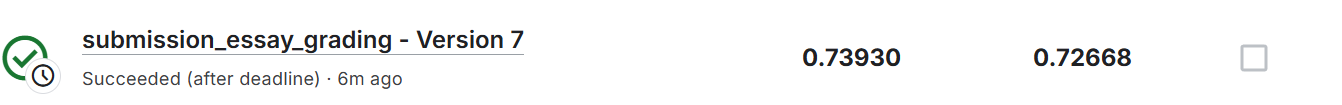  
Best scores are around 0.82.  

# Conclusion and Discussion  

#### The Main Results  
During the project I have performed preprocessing of the data: text cleaning, TF-IDF embaddings preparation.  
EDA analysis demosnstrated class disbalance, which was adressed during the training.  
It was also noticed that lenght of the essay itself was a good predictor for the grade.  

Various approaches were used to predict the outcome: classical ML models (dummy, linear regression, boosting), custom neural nets, BERT and modern LLM (Grok3).  
Modern LLM performed the worst out of box, even thought they are famous for zero-shot capabilities.  
Linear Regression was comparable with custom neural nets.  
The best was boosting, however, BERT would, likely, outperform it if more computational power would be available.  


#### Key takeaways  
- Some ML problems are not that easy to classify, like with this example there is no clear decision in favour of regression or classification of ordered target  
- Modern LLMs without any additions are not that good for problems, where one can cleary evaluate the result  
- Classical ML algorythms are still very good for NLP problems  

#### Points of to improve  
- Fine-tuning an LLM could improve it performance  
- More computational resources can be utilized for BERT to achiave better results  
- BERT with classification output may be better  


#### References  
Link to the Kaggle competition: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview  
GitHub repo: https://github.com/IMosia/essay_evaluation  
Information about BERT: https://huggingface.co/docs/transformers/model_doc/bert  
GROK documentation: https://docs.x.ai/docs/guides/chat  
Library for Keras visualization: https://github.com/paulgavrikov/visualkeras/  
Distilled BERT: https://huggingface.co/distilbert/distilbert-base-uncased  
